In [1]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from econml.dr import DRLearner
from econml.sklearn_extensions.model_selection import GridSearchCVList
from statsmodels.api import OLS, add_constant
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, LinearRegression

In [2]:
file_path = 'F:/PhD/2nd Year Paper/Data/filtered_data.csv'
data = pd.read_csv(file_path)

filtered_data = data.copy()

## ML Treatment
filtered_data['mltreat'] = (filtered_data['treatols19'] | filtered_data['treatols20']).astype(int)
filtered_data['year'] = pd.to_numeric(filtered_data['year'], errors='coerce')

# Sort and create lags
filtered_data = filtered_data.sort_values(by=['name', 'year']).reset_index(drop=True)
lag_vars = ['hexpf_adjusted', 'hos_num', 'annual_patient', 'gdp_adjusted', 'population', 'mltreat']
for var in lag_vars:
    filtered_data[f'{var}_lag1'] = filtered_data.groupby('name')[var].shift(1)

# Drop rows with missing lag values
filtered_data = filtered_data.dropna(subset=[f'{v}_lag1' for v in lag_vars])

# Define outcome and treatment
T = filtered_data['mltreat'].reset_index(drop=True)
Y = filtered_data['hexpf_adjusted'].reset_index(drop=True)

# Define continuous features
X_continuous = filtered_data[
    ['hos_num', 'annual_patient', 'gdp_adjusted', 'population'] +
    [f'{v}_lag1' for v in ['hexpf_adjusted', 'hos_num', 'annual_patient', 'gdp_adjusted', 'population', 'mltreat']]
]

# Create year dummies (as string to prevent unwanted sorting issues)
year_dummies = pd.get_dummies(filtered_data['year'].astype(str), prefix='year', drop_first=True)
region_dummies = pd.get_dummies(filtered_data[['region']], drop_first=True)

# Step 5a: X_y includes everything (lags, year FE, region)
X_y = pd.concat([X_continuous, year_dummies, region_dummies], axis=1)

# Step 5b: X_t excludes year FE and lags
X_t = filtered_data[['hos_num', 'annual_patient', 'gdp_adjusted', 'population']].copy()

# Reset index for safety
X_y = X_y.reset_index(drop=True)
X_t = X_t.reset_index(drop=True)

In [13]:
def plot_and_summarize(results, save_path="F:/PhD/2nd Year Paper/Graphs/ate_distribution.png"):

    # Plot the KDE distributions
    plt.figure(figsize=(12, 6))
    for name, values in results.items():
        sns.kdeplot(values, label=name, fill=True)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Estimator ATE Distributions")
    plt.xlabel("Estimated ATE")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()

    # Save the plot
    plt.savefig(save_path, dpi=300)
    print(f"Plot saved to: {save_path}")

    # Show the plot
    plt.show()

    # Print summary statistics
    for method, vals in results.items():
        mean = np.mean(vals)
        std = np.std(vals, ddof=1)
        var = np.var(vals, ddof=1)
        print(f"{method} - Mean: {mean:.4f}, Std: {std:.4f}, Var: {var:.6f}")
    

In [10]:
def crossfit_predict_groupwise(model, X, Y, mask, n_splits=2):
    """ Cross-fitted predictions using only rows where mask is True (e.g., T == 1 or T == 0) """
    X = pd.DataFrame(X).reset_index(drop=True)
    Y = pd.Series(Y).reset_index(drop=True)
    mask = pd.Series(mask).reset_index(drop=True)

    X_sub = X[mask].reset_index(drop=True)
    Y_sub = Y[mask].reset_index(drop=True)

    pred = np.zeros(len(X))  # Predict for all, fill with valid predictions only where applicable
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(X_sub):
        m = model.__class__(**model.get_params()).fit(X_sub.iloc[train_idx], Y_sub.iloc[train_idx])
        pred_idx = mask[mask].index[test_idx]  # map back to original index
        pred[pred_idx] = m.predict(X.iloc[pred_idx])

    return pred

def crossfit_predict(model, X, Y, n_splits=2):
    X = pd.DataFrame(X).reset_index(drop=True)  # ensure DataFrame
    Y = pd.Series(Y).reset_index(drop=True)     # ensure Series
    pred = np.zeros(len(Y))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for train_idx, test_idx in kf.split(X):
        m = model.__class__(**model.get_params()).fit(X.iloc[train_idx], Y.iloc[train_idx])
        pred[test_idx] = m.predict(X.iloc[test_idx])
    return pred

def bootstrap_2020_estimators_rf(X_y, X_t, T, Y, years, n_bootstrap=30):
    results = {
        'AIPW': [],
        'X-learner': [],
        'DR-learner': [],
        'CausalForest': []
    }

    for _ in range(n_bootstrap):
        try:
            # Bootstrap sample
            idx = np.random.choice(len(Y), size=len(Y), replace=True)
            X_y_b = pd.DataFrame(X_y).iloc[idx].reset_index(drop=True)
            X_t_b = pd.DataFrame(X_t).iloc[idx].reset_index(drop=True)
            T_b = pd.Series(np.array(T)[idx]).reset_index(drop=True)
            Y_b = pd.Series(np.array(Y)[idx]).reset_index(drop=True)

            # Identify 2020 rows
            year_vals = pd.Series(years).iloc[idx].reset_index(drop=True)
            mask_2020 = year_vals >= 2020

            # Propensity score model
            e_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=500, random_state=42)
            e_hat_full = crossfit_predict(e_model, X_t_b, T_b)
            #e_hat_full = np.clip(e_hat_full, 0.05, 0.98)

            # Outcome models
            mu1_model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=10, random_state=42)
            mu0_model = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=10, random_state=42)

            mu1_hat_full = crossfit_predict_groupwise(mu1_model, X_y_b, Y_b, mask=(T_b == 1))
            mu0_hat_full = crossfit_predict_groupwise(mu0_model, X_y_b, Y_b, mask=(T_b == 0))

            # AIPW
            aipw_scores = ((T_b - e_hat_full) / (e_hat_full * (1 - e_hat_full))) * \
                          (Y_b - T_b * mu1_hat_full - (1 - T_b) * mu0_hat_full) + \
                          (mu1_hat_full - mu0_hat_full)
            ate_aipw_2020 = np.mean(aipw_scores[mask_2020])
            results['AIPW'].append(ate_aipw_2020)
            outcome_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
            treatment_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=500, random_state=42)
            # DR-learner
            dr = DRLearner(
                model_regression=outcome_model,
                model_propensity=RandomForestClassifier(n_estimators=200, max_depth=4, random_state=42),
                model_final=RandomForestRegressor(n_estimators=100)
            )
            dr.fit(Y_b, T_b, X=X_y_b, W=X_t_b)
            tau_dr = dr.effect(X_y_b[mask_2020])
            results['DR-learner'].append(np.mean(tau_dr))

            # Causal Forest
            cf = CausalForestDML(
            model_y=outcome_model,
            model_t=treatment_model,
            discrete_treatment=True,
            n_estimators=100,
            subforest_size=10,
            min_samples_leaf=10,
            max_depth=5,
            random_state=42,
            cv=2
            )
            cf.fit(Y_b, T_b, X=X_y_b, W=X_t_b)
            tau_cf = cf.effect(X_y_b[mask_2020])
            results['CausalForest'].append(np.mean(tau_cf))

            # X-learner
            tau_control = mu1_hat_full[T_b == 0] - Y_b[T_b == 0]
            tau_treat = Y_b[T_b == 1] - mu0_hat_full[T_b == 1]

            rf_tau0 = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42).fit(X_y_b[T_b == 0], tau_control)
            rf_tau1 = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42).fit(X_y_b[T_b == 1], tau_treat)

            cate_0 = rf_tau0.predict(X_y_b[mask_2020])
            cate_1 = rf_tau1.predict(X_y_b[mask_2020])
            cate_x = (1 - e_hat_full[mask_2020]) * cate_1 + e_hat_full[mask_2020] * cate_0
            results['X-learner'].append(np.mean(cate_x))

        except Exception as e:
            print(f"Skipped iteration: {str(e)[:100]}")
            continue

    return results

In [ ]:
results_2020 = bootstrap_2020_estimators_rf(
    X_y=X_y.reset_index(drop=True),
    X_t=X_t.reset_index(drop=True),
    T=T.reset_index(drop=True),
    Y=Y.reset_index(drop=True),
    years=filtered_data['year'].reset_index(drop=True),
    n_bootstrap=50
)

C:\Users\yizho\AppData\Local\Temp\ipykernel_26180\3208443360.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(values, label=name, fill=True)


Plot saved to: F:/PhD/2nd Year Paper/Graphs/ate_distribution.png


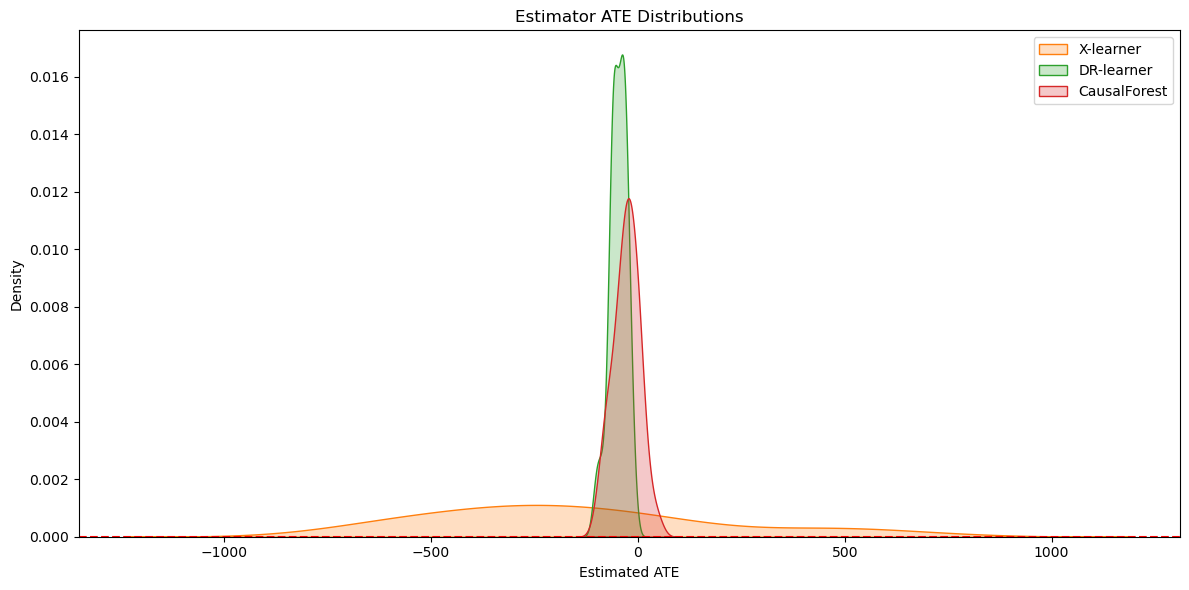

AIPW - Mean: nan, Std: nan, Var: nan
X-learner - Mean: -153.4801, Std: 354.4493, Var: 125634.307524
DR-learner - Mean: -48.2725, Std: 20.7066, Var: 428.764995
CausalForest - Mean: -28.6659, Std: 31.5791, Var: 997.241618


In [14]:
plot_and_summarize(results_2020, save_path="F:/PhD/2nd Year Paper/Graphs/ate_distribution.png")

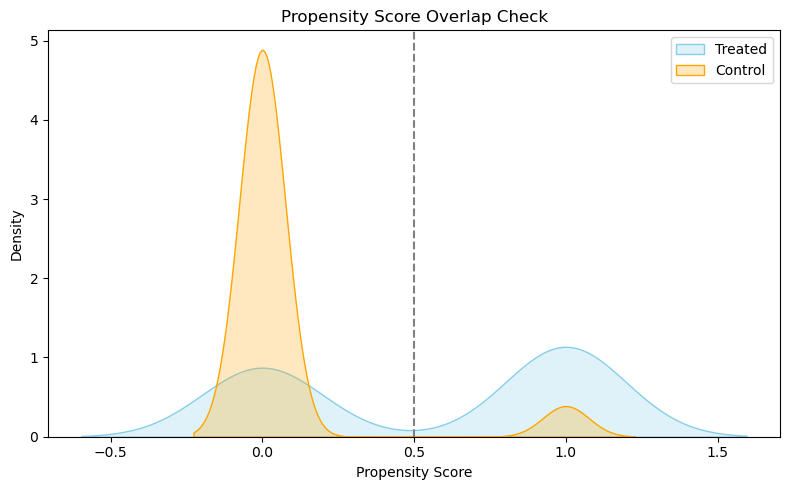

In [220]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_overlap(e_hat, T):
    plt.figure(figsize=(8, 5))
    sns.kdeplot(e_hat[T == 1], label='Treated', fill=True, color='skyblue')
    sns.kdeplot(e_hat[T == 0], label='Control', fill=True, color='orange')
    plt.title("Propensity Score Overlap Check")
    plt.xlabel("Propensity Score")
    plt.ylabel("Density")
    plt.axvline(0.5, color='gray', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

rf_model = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=500, random_state=42)
e_hat_rf = crossfit_predict(rf_model, X_t, T)

plot_overlap(e_hat_rf, T)
